# Iterative Methods for solving Laplace Equation

In this notebook, we will learn how to solve the Laplace's equation with iteractive methods.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads
import time

## Mesh Generation

Before we start solving the Laplace's euqtion, we need to generate the mesh first.

In [2]:
def generate_mesh(nx, ny, buff, 
                  xmin=0.0, xmax=1.0, ymin=0.0, ymax=1.0):
    """
    Generate 2D mesh grids for solving Laplace equation.

    Parameters
    ----------
    nx : int
        Number of grid points in x direction.
    ny : int
        Number of grid points in y direction.
    buff : int
        Number of ghost cells around the domain.
    xmin : float
        Minimum value of x.
    xmax : float
        Maximum value of x.
    ymin : float
        Minimum value of y.
    ymax : float
        Maximum value of y.

    Returns
    -------
    x : 2D numpy array
        Mesh grid for x.
    y : 2D numpy array
        Mesh grid for y.

    dx : float
        Grid spacing in x.
    dy : float
        Grid spacing in y.
        
    """
    #TODO:

    u = np.zeros((nx+2*buff, ny+2*buff))
    x = np.linspace(xmin, xmax, nx+2*buff)
    y = np.linspace(ymin, ymax, ny+2*buff)
    dx = x[1] - x[0]
    dy = y[1] - y[0]

    return u, x, y, dx, dy 
   

## Jacobi method

Recall the finite difference equations for the Laplace's equation, we have

$$
u_{i,j}^{k+1} = \frac{1}{4}(u_{i-1,j}^k + u_{i,j-1}^k + u_{i+1,j}^k + u_{i,j+1}^k)
$$


### Exercise: Jacobi method

* A unit square with $N \times N$ grids
* Need one layer of ghost cells for boundary conditions
* Boundary Conditions: 1 on the top BC; others are 0 
* Once we have the mesh, implment the jacobi method by
1. Write a function called `jacobi` to implment one Jacobi iteration
2. Write a function called `update_bc` to update the boundary conditions.
3. Write a function called `relax` to iterate the matrix unitl the error matches a tolerance (loop through $k$). 
* Error can be defined by $\sqrt{\sum (u_{\rm ij}- u_{\rm old,ij})^2}/N_{\rm cells}$
* The `jacobi` function need to be acclerated by `numba`
* For debugging, you could start from a bigger tolerance first. 
* The your `relax` function with $32\times 32$, $64 \times 64$, and $128 \times 128$ grids.
* Plot errors vs. #iterations, to see how it converges. 

c:\Users\yqiu7\.conda\envs\ComputationalPhysics113\Lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Converged after 2154 iterations with error 0.000001
Converged after 8335 iterations with error 0.000001
Did not converge within the maximum number of iterations.


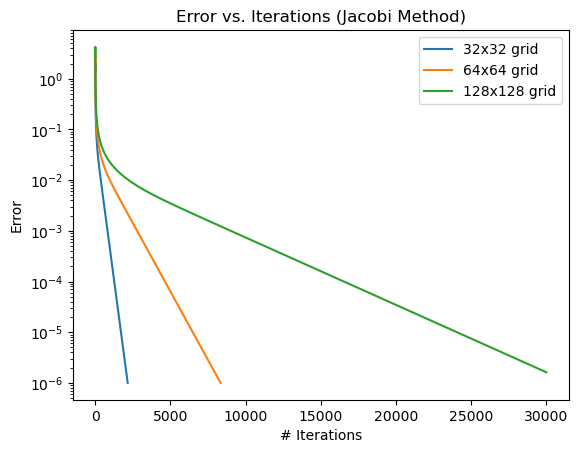

In [ ]:

@njit(nopython=True)
def jacobi(u, u_old, dx, dy, N):

    for i in range(1, N - 1):  
        for j in range(1, N - 1):
            u[i, j] = 0.25 * (
                u_old[i-1, j] + u_old[i+1, j] +
                u_old[i, j-1] + u_old[i, j+1]
            )
    return u

def update_bc(u, N):

    u[0, :] = 1  # Top boundary
    u[-1, :] = 0  # Bottom boundary
    u[:, 0] = 0  # Left boundary
    u[:, -1] = 0  # Right boundary

def relax(N, tol=1e-6, max_iter=30000):

    # Grid spacing
    dx = 1.0 / (N + 1)
    dy = 1.0 / (N + 1)
    
    # Initialize solution arrays (with ghost cells)
    u = np.zeros((N + 2, N + 2))
    u_old = np.zeros((N + 2, N + 2))
    
    # Update boundary conditions
    update_bc(u, N)
    update_bc(u_old, N)
    
    # Initialize error tracking
    errors = []
    
    for k in range(max_iter):
        # Perform Jacobi iteration
        uold = u.copy()
        jacobi(u, u_old, dx, dy, N)
        
        # Compute error
        # error = np.sqrt(np.sum((u[1:-1, 1:-1] - u_old[1:-1, 1:-1])**2) / (N * N))
        error = np.linalg.norm(u - uold)
        errors.append(error)
        
        # Check for convergence
        if error < tol:
            print(f"Converged after {k + 1} iterations with error {error:.6f}")
            return u, errors, k + 1
        
        # Swap references for the next iteration
        u_old, u = u, u_old
    
    print("Did not converge within the maximum number of iterations.")
    return u, errors, max_iter

# Testing and Plotting
grid_sizes = [32, 64, 128]
for N in grid_sizes:
    u, errors, iterations = relax(N, tol=1e-6)
    plt.plot(range(iterations), errors, label=f"{N}x{N} grid")

plt.xlabel("# Iterations")
plt.ylabel("Error")
plt.yscale("log")
plt.legend()
plt.title("Error vs. Iterations (Jacobi Method)")
plt.show()


# Gauss-Seidel Method

* Gauss-Seidel meothd remedies this by using each new component of solution as soon as it has been computed. 

$$
{\rm Gauss-Seidel: } u_{i,j}^{k+1} = \frac{1}{4}(u_{i-1,j}^{k+1} + u_{i,j-1}^{k+1} + u_{i+1,j}^k + u_{i,j+1}^k)
$$


* The Gauss-Seidel method averages solution values at four surrounding grid points, but always use new component values as soon as they become available, rather than waiting until current iteration has been completed.
* No need a copy of `u`.
* Gauss-Seidel method does not always converge, but it is guaranteed to converge under conditions that are often satisfied in practice.
* Although Gauss-Seidel converges more rapidly than the Jacobi method, it is often still too slow to be practical.

### Exercise: Gauss-Seidel Method

* Modify your `relax` function to support the Gauss-Seidel Method
* write a function `gauss_seidel()` to implement one Gauss-Seidel iteration.
* The `gauss_seidel()` function need to be accelerated by numba.
* Compare the number of iterations (and the computing time) between Jacobi method and Gauss-Seidel method. 

c:\Users\yqiu7\.conda\envs\ComputationalPhysics113\Lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Converged after 1234 iterations with error 9.909870e-07
Converged after 2066 iterations with error 9.962656e-07
Converged after 4511 iterations with error 9.993462e-07
Converged after 7971 iterations with error 9.992999e-07
Converged after 16644 iterations with error 9.997567e-07
Did not converge within the maximum number of iterations.


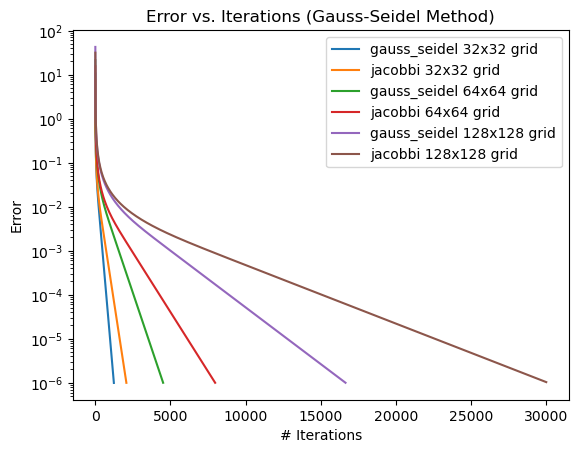

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

@njit(nopython=True)
def gauss_seidel(u, dx, dy, N):
    """
    Perform one iteration of the Gauss-Seidel method to update the solution.
    """
    for i in range(1, N + 1):  
        for j in range(1, N + 1):
            u[i, j] = 0.25 * (
                u[i-1, j] + u[i+1, j] +
                u[i, j-1] + u[i, j+1]
            )

def update_bc(u, N):
    """
    Update the boundary conditions for the grid.
    """
    u[0, :] = 1.0  # Top boundary
    u[-1, :] = 0.0  # Bottom boundary
    u[:, 0] = 0.0  # Left boundary
    u[:, -1] = 0.0  # Right boundary

def relax(method, N, tol=1e-6, max_iter=30000):
    """
    Perform relaxation using the specified method (e.g., 'gauss_seidel').
    """
    # Grid spacing
    dx = 1.0 / (N + 1)
    dy = 1.0 / (N + 1)
    
    # Initialize solution array (with ghost cells)
    u = np.zeros((N + 2, N + 2))
    
    # Update boundary conditions
    update_bc(u, N)
    
    # Initialize error tracking
    errors = []
    
    for k in range(max_iter):
        # Save the old solution for error calculation
        uold = u.copy()
        
        # Perform one iteration of the specified method
        if method == 'gauss_seidel':
            gauss_seidel(u, dx, dy, N)
        if method == 'jacobbi':
            jacobi(u, uold, dx, dy, N)
        
        # Compute error
        error = np.linalg.norm(u - uold, ord=np.inf)
        errors.append(error)
        
        # Check for convergence
        if error < tol:
            print(f"Converged after {k + 1} iterations with error {error:.6e}")
            return u, errors, k + 1

    print("Did not converge within the maximum number of iterations.")
    return u, errors, max_iter

# Testing and Plotting
grid_sizes = [32, 64, 128]
for N in grid_sizes:
    u, errors, iterations = relax('gauss_seidel', N, tol=1e-6)
    plt.plot(range(len(errors)), errors, label=f"gauss_seidel {N}x{N} grid")
    u, errors, iterations = relax('jacobbi', N, tol=1e-6)
    plt.plot(range(len(errors)), errors, label=f"jacobbi {N}x{N} grid")

plt.xlabel("# Iterations")
plt.ylabel("Error")
plt.yscale("log")
plt.legend()
plt.title("Error vs. Iterations (Gauss-Seidel Method)")
plt.show()


# Successive Over-Relaxation (SOR)

* Convergence rate of Gauss-Seidel can be accelerated by successive over-relaxation (SOR) method. 
* Starting with $x^k$ first, compute next iterate that would be given by Gauss-Seidel $x_{GS}^{k+1}$, then instead take next iterate to be

$$
x^{k+1} = x^k + \omega(x_{GS}^{k+1} - x^k) = (1-\omega)x^k + \omega x_{GS}^{k+1}
$$

*  Which is weighted average of current iterate and next GS iterate
* $w$ is a fixed relaxation parameter chosen to accelerate convergence
* $w > 1$ gives over-relaxation
* $w<1$ gives under-relaxation
* $w=1$ gibes Gauss-Seidel meothd
* Method diverges unless $0 < w < 2$, but choosing optimal $w$ is difficult in general. 

### Exercise: Successive Over-Relaxation

* Consider $64 \times 64$ first for developing the solver
* Write a function called `successive_over_relax()` to implement one SOR iteration.
* Modify the `relax()` to support the SOR method.
* The `successive_over_relax()` function need to be accelerated by `numba`.
* Compare the number of iterations (and the computing time) with all other methods. 

c:\Users\yqiu7\.conda\envs\ComputationalPhysics113\Lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


GAUSS_SEIDEL converged after 16644 iterations with error 9.997567e-07 in 0.88 seconds.
JACOBBI did not converge within 30000 iterations.
SOR converged after 11540 iterations with error 9.995396e-07 in 1.03 seconds.
SOR converged after 4714 iterations with error 9.997979e-07 in 0.37 seconds.
SOR converged after 2213 iterations with error 9.977523e-07 in 0.17 seconds.
SOR converged after 1059 iterations with error 9.889009e-07 in 0.09 seconds.


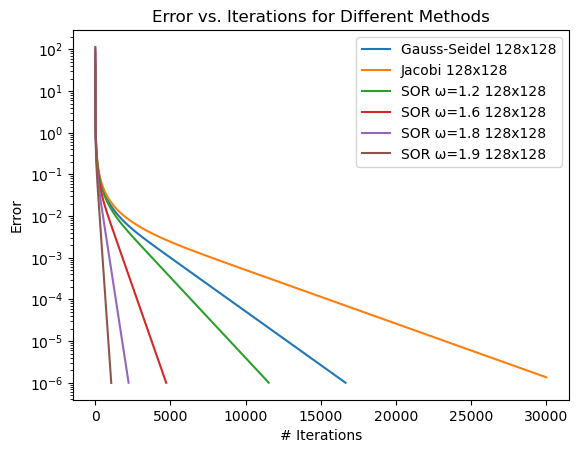

In [32]:
#TODO

@njit(nopython=True)
def successive_over_relax(u, omega, dx, dy, N):
    uold = u.copy()
    for i in range(1, N + 1):
        for j in range(1, N + 1):
            gs = 0.25 * (
                u[i-1, j] + u[i+1, j] +
                u[i, j-1] + u[i, j+1]
            )
            
            u[i, j] = (1 - omega) * uold[i, j] + omega * gs

def update_bc(u, N):
    """
    Update the boundary conditions for the grid.
    """
    u[0, :] = 1.0  # Top boundary
    u[-1, :] = 0.0  # Bottom boundary
    u[:, 0] = 0.0  # Left boundary
    u[:, -1] = 0.0  # Right boundary

def relax(method, N, tol=1e-6, max_iter=30000, omega=1.0):
    """
    Perform relaxation using the specified method (e.g., 'gauss_seidel', 'jacobi', 'sor').
    """
    # Grid spacing
    dx = 1.0 / (N + 1)
    dy = 1.0 / (N + 1)
    
    # Initialize solution array 
    u = np.zeros((N + 2, N + 2))
    
    # Update boundary conditions
    update_bc(u, N)
    
    # Initialize error tracking
    errors = []
    start_time = time.time()
    
    for k in range(max_iter):
        # Save the old solution for error calculation
        uold = u.copy()
        
        # Perform one iteration of the specified method
        if method == 'gauss_seidel':
            gauss_seidel(u, dx, dy, N)
        elif method == 'jacobbi':
            jacobi(u, uold, dx, dy, N)
        elif method == 'sor':
            successive_over_relax(u, omega, dx, dy, N)
        
        # Compute error
        error = np.linalg.norm(u - uold, ord=np.inf)
        errors.append(error)
        
        # Check for convergence
        if error < tol:
            elapsed_time = time.time() - start_time
            print(f"{method.upper()} converged after {k + 1} iterations with error {error:.6e} in {elapsed_time:.2f} seconds.")
            return u, errors, k + 1

    elapsed_time = time.time() - start_time
    print(f"{method.upper()} did not converge within {max_iter} iterations.")
    return u, errors, max_iter

# Testing and Plotting
grid_sizes = [128]
omega_values = [1.2, 1.6, 1.8, 1.9]  # Different omega values for SOR

for N in grid_sizes:
    # Gauss-Seidel
    u, errors, iterations = relax('gauss_seidel', N, tol=1e-6)
    plt.plot(range(len(errors)), errors, label=f"Gauss-Seidel {N}x{N}")
    
    # Jacobi
    u, errors, iterations = relax('jacobbi', N, tol=1e-6)
    plt.plot(range(len(errors)), errors, label=f"Jacobi {N}x{N}")
    
    # SOR with different omega values
    for omega in omega_values:
        u, errors, iterations = relax('sor', N, tol=1e-6, omega=omega)
        plt.plot(range(len(errors)), errors, label=f"SOR ω={omega} {N}x{N}")

plt.xlabel("# Iterations")
plt.ylabel("Error")
plt.yscale("log")
plt.legend()
plt.title("Error vs. Iterations for Different Methods")
plt.show()



## Extending to Poisson's equation

* Extend your solver for solving Poisson's eq. 
* Question: How to modify the Gauss-Seidel's method?
* Consider a $128\times 128$ grids in a domain ($-1<x<1$; $-1<y<1$)
* Assume $\rho(r)= e^{-10r}$, 
* Assume $u=0$ on all four boundaries.
* Solve for the potential "$u$".

c:\Users\yqiu7\.conda\envs\ComputationalPhysics113\Lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Converged after 10724 iterations with error 9.996134e-07


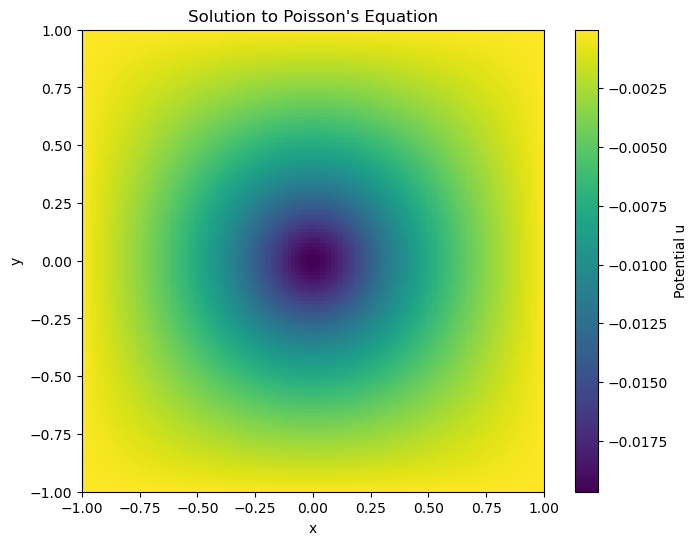

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

@njit(nopython=True)
def gauss_seidel_poisson(u, rho, dx, dy, N):
    for i in range(1, N + 1):  
        for j in range(1, N + 1):
            u[i, j] = 0.25 * (
                u[i-1, j] + u[i+1, j] +
                u[i, j-1] + u[i, j+1] -
                dx**2 * rho[i-1, j-1]
            )

def update_bc(u, N):
    u[0, :] = 0.0  # Top boundary
    u[-1, :] = 0.0  # Bottom boundary
    u[:, 0] = 0.0  # Left boundary
    u[:, -1] = 0.0  # Right boundary

def solve_poisson(N, tol=1e-6, max_iter=30000):
    """
    Solve Poisson's equation using the Gauss-Seidel method.
    """
    # Grid spacing
    dx = 2.0 / (N - 1)
    dy = 2.0 / (N - 1)
    
    # Generate the rho matrix (source term)
    x = np.linspace(-1, 1, N)
    y = np.linspace(-1, 1, N)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    rho = np.exp(-10 * r)
    
    # Initialize solution array (with ghost cells)
    u = np.zeros((N + 2, N + 2))
    
    # Update boundary conditions
    update_bc(u, N)
    
    # Initialize error tracking
    errors = []
    
    for k in range(max_iter):
        # Save the old solution for error calculation
        uold = u.copy()
        
        # Perform one iteration of the Gauss-Seidel method
        gauss_seidel_poisson(u, rho, dx, dy, N)
        
        # Compute error
        error = np.linalg.norm(u - uold, ord=np.inf)
        errors.append(error)
        
        # Check for convergence
        if error < tol:
            print(f"Converged after {k + 1} iterations with error {error:.6e}")
            return u[1:-1, 1:-1], errors, k + 1

    print("Did not converge within the maximum number of iterations.")
    return u[1:-1, 1:-1], errors, max_iter

# Solve Poisson's equation for a 128x128 grid
N = 128
u, errors, iterations = solve_poisson(N)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.imshow(u, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
plt.colorbar(label='Potential u')
plt.title("Solution to Poisson's Equation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot the error convergence
# plt.figure(figsize=(8, 6))
# plt.plot(range(len(errors)), errors, label="Error")
# plt.yscale("log")
# plt.xlabel("Iteration")
# plt.ylabel("Error")
# plt.title("Error Convergence (Gauss-Seidel Method)")
# plt.legend()
# plt.show()


# Multigrids methods

* Write two functions to implement the restriction and prolongation of grids.
* Apply the multigrid methods for solving Laplace/Poisson equation
* Redo the error convergence with multigrid methods

In [ ]:
@njit
def restrict(fine):
    """
    Restriction: Transfer fine grid to coarse grid using full-weighting.
    """
    N = fine.shape[0] - 2
    coarse = np.zeros((N // 2 + 2, N // 2 + 2))
    for i in range(1, N // 2 + 1):
        for j in range(1, N // 2 + 1):
            coarse[i, j] = (
                            0.25 * (fine[2*i-1, 2*j-1] + fine[2*i-1, 2*j+1] +
                                    fine[2*i+1, 2*j-1] + fine[2*i+1, 2*j+1]))
    return coarse

@njit
def prolong(coarse):
    """
    Prolongation: Transfer coarse grid to fine grid using bilinear interpolation.
    """
    N = coarse.shape[0] - 2
    fine = np.zeros((2*N + 2, 2*N + 2))
    for i in range(1, N + 1):
        for j in range(1, N + 1):
            fine[2*i, 2*j] = coarse[i, j]
            fine[2*i+1, 2*j] = coarse[i, j]
            fine[2*i, 2*j+1] = coarse[i, j]
            fine[2*i+1, 2*j+1] = coarse[i, j]
    return fine

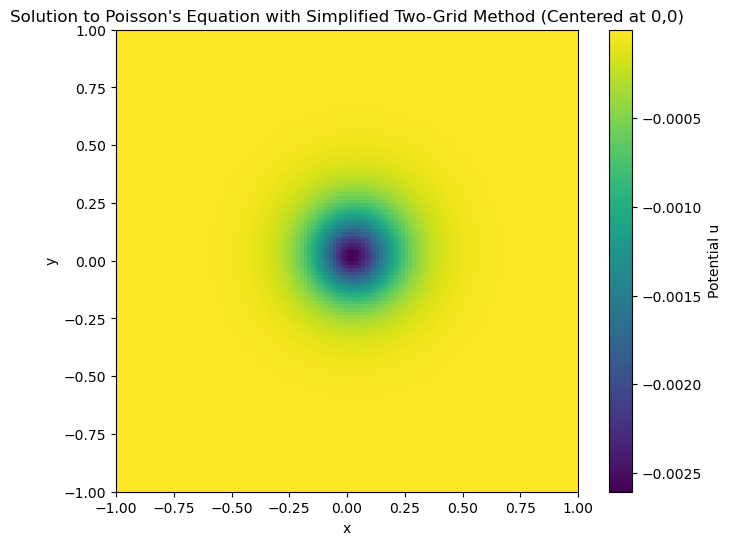

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

@njit
def restrict(fine):
    """
    Restriction: Transfer fine grid to coarse grid using full-weighting.
    """
    N = fine.shape[0] - 2
    coarse = np.zeros((N // 2 + 2, N // 2 + 2))
    for i in range(1, N // 2 + 1):
        for j in range(1, N // 2 + 1):
            coarse[i, j] = (
                            0.25 * (fine[2*i-1, 2*j-1] + fine[2*i-1, 2*j+1] +
                                    fine[2*i+1, 2*j-1] + fine[2*i+1, 2*j+1]))
    return coarse

@njit
def prolong(coarse):
    """
    Prolongation: Transfer coarse grid to fine grid using bilinear interpolation.
    """
    N = coarse.shape[0] - 2
    fine = np.zeros((2*N + 2, 2*N + 2))
    for i in range(1, N + 1):
        for j in range(1, N + 1):
            fine[2*i, 2*j] = coarse[i, j]
            fine[2*i+1, 2*j] = coarse[i, j]
            fine[2*i, 2*j+1] = coarse[i, j]
            fine[2*i+1, 2*j+1] = coarse[i, j]
    return fine

@njit
def gauss_seidel_poisson(u, f, dx, N):
    """
    Perform one iteration of the Gauss-Seidel method for Poisson's equation.
    """
    for i in range(1, N + 1):
        for j in range(1, N + 1):
            u[i, j] = 0.25 * (
                u[i-1, j] + u[i+1, j] +
                u[i, j-1] + u[i, j+1] - dx**2 * f[i-1, j-1]
            )

def relax(u, f, dx, pre_smooth=3, post_smooth=3):
    """
    Simplified Two-Grid method for Poisson's equation without residual computation.
    """
    N = u.shape[0] - 2
    for _ in range(pre_smooth):
        gauss_seidel_poisson(u, f, dx, N)
    coarse_u = restrict(u)
    coarse_f = restrict(f)
    for _ in range(10):  # Perform a few Gauss-Seidel iterations on coarse grid
        gauss_seidel_poisson(coarse_u, coarse_f, 2 * dx, coarse_u.shape[0] - 2)
    u = prolong(coarse_u)
    for _ in range(post_smooth):
        gauss_seidel_poisson(u, f, dx, N)
    return u

# Solve Poisson's equation using the simplified two-grid method
N = 128  # Number of grid points in each dimension
dx = 2.0 / (N - 1)
x = np.linspace(-1, 1, N)  # Ensure the center is at x = 0
y = np.linspace(-1, 1, N)  # Ensure the center is at y = 0
X, Y = np.meshgrid(x, y)
r = np.sqrt(X**2 + Y**2)
f = np.exp(-10 * r)  # Source term centered at (0, 0)

u = np.zeros((N + 2, N + 2))  # Initial guess
u = relax(u, f, dx)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.imshow(u[1:-1, 1:-1], extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
plt.colorbar(label='Potential u')
plt.title("Solution to Poisson's Equation with Simplified Two-Grid Method (Centered at 0,0)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
